In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity,euclidean_distances
from sklearn.impute import KNNImputer
import networkx as nx
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

# class GCN(torch.nn.Module):
#     def __init__(self, num_features, hidden_channels, num_classes):
#         super(GCN, self).__init__()
#         self.conv1 = GCNConv(num_features, hidden_channels)
#         self.conv2 = GCNConv(hidden_channels, num_classes)

#     def forward(self, x, edge_index):
#         x = self.conv1(x, edge_index)
#         x = F.relu(x)
#         x = F.dropout(x, p=0.5, training=self.training)
#         x = self.conv2(x, edge_index)
#         return x

c:\Users\thanh\OneDrive - Queensland University of Technology\dataPHD\pytorchhere.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_0= pd.read_excel('./Music_InCarMusic/Data_InCarMusic.xlsx',sheet_name=0)
df_1= pd.read_excel('./Music_InCarMusic/Data_InCarMusic.xlsx',sheet_name=1)
df_2= pd.read_excel('./Music_InCarMusic/Data_InCarMusic.xlsx',sheet_name=2)
df_3= pd.read_excel('./Music_InCarMusic/Data_InCarMusic.xlsx',sheet_name=3)
from itertools import product

def grid_search(model, param_grid, n_iter=300):
    best_loss = float('inf')
    best_params = None
    for params in product(*param_grid.values()):
        params = dict(zip(param_grid.keys(), params))
        mf = model(**params)
        mf.factorize(iter=n_iter)
        loss = mf.total_loss[-1]
        if loss < best_loss:
            best_loss = loss
            best_params = params
    print('Best parameters:', best_params)
    print('Best loss:', best_loss)
    return best_params


#remove all 0 
df =df_0[df_0[' Rating'] != 0].reset_index(drop=True)
# dictionary for 'DrivingStyle' column
map_DrivingStyle = {'relaxed driving': 1, 'sport driving': 2}

# dictionary for 'RoadType' column
map_RoadType = {'urban': 1, 'mountains': 2, 'country side': 3, 'coast line': 4}

# dictionary for 'Mood' column
map_Mood = {'sad': 1, 'lazy': 2, 'active': 3, 'happy': 4}

# dictionary for 'TimeOfDay' column
map_TimeOfDay = {'night': 1, 'morning': 2, 'day time': 3, 'afternoon': 4}

# dictionary for 'RoadCondition' column
map_RoadCondition = {'city': 1, 'serpentine': 2, 'highway': 3}

# dictionary for 'Alertness' column
map_Alertness = {'sleepy': 1, 'awake': 2}

# dictionary for 'Traffic' column
map_Traffic = {'traffic jam': 1, 'lots of cars': 2, 'free road': 3}

# dictionary for 'Weather' column
map_Weather = {'sunny': 1, 'snowing': 2, 'rainy': 3, 'cloudy': 4}
# create a list of variable names
variable_names = [map_DrivingStyle, map_RoadType, map_Mood, map_TimeOfDay, map_RoadCondition, map_Alertness, map_Traffic, map_Weather]

for i,j in zip(df.columns[3:],variable_names): 
    df[i]= df[i].map(j)


In [3]:
df_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4012 entries, 0 to 4011
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   UserID             4012 non-null   int64 
 1   ItemID             4012 non-null   int64 
 2    Rating            4012 non-null   int64 
 3   DrivingStyle       353 non-null    object
 4   landscape          505 non-null    object
 5   mood               406 non-null    object
 6   naturalphenomena   396 non-null    object
 7   RoadType           396 non-null    object
 8   sleepiness         157 non-null    object
 9   trafficConditions  399 non-null    object
 10  weather            397 non-null    object
dtypes: int64(3), object(8)
memory usage: 344.9+ KB


In [4]:
def cal(df):

    
    # calculate total number of possible user-item interactions
    num_users = df[df.columns[0]].nunique()
    num_items = df[df.columns[1]].nunique()
    num_possible_interactions = num_users * num_items
    
    # calculate total number of actual user-item interactions
    num_actual_interactions = df.shape[0]
    
    # calculate sparsity of ratings
    sparsity = 1 - (num_actual_interactions / num_possible_interactions)
    
    print(sparsity)

cal(df)

0.3336759164097294


In [5]:
neighbors=int(df['UserID'].value_counts().mean())
neighbors

92

In [6]:
df_2[' artist'].value_counts()
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
df_2[' artist']=label.fit_transform(df_2[' artist'])

In [7]:
df_2[' artist'].value_counts()

114    4
68     4
110    3
17     3
91     3
      ..
20     1
1      1
88     1
78     1
37     1
Name:  artist, Length: 119, dtype: int64

In [8]:
df.info()
driving = df[['UserID','ItemID',' Rating','DrivingStyle']]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3890 entries, 0 to 3889
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   UserID             3890 non-null   int64  
 1   ItemID             3890 non-null   int64  
 2    Rating            3890 non-null   int64  
 3   DrivingStyle       341 non-null    float64
 4   landscape          486 non-null    float64
 5   mood               393 non-null    float64
 6   naturalphenomena   387 non-null    float64
 7   RoadType           386 non-null    float64
 8   sleepiness         151 non-null    float64
 9   trafficConditions  386 non-null    float64
 10  weather            387 non-null    float64
dtypes: float64(8), int64(3)
memory usage: 334.4 KB


In [9]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
from random import choice

# Load your datasets
# music_df = pd.read_csv('music.csv')
# rating_df = pd.read_csv('rating.csv')
music_df = df_2
# Step 1: Calculate similarity between songs
music_features = df_2[[' artist', ' category_id']]
distance_matrix = cosine_similarity(music_features)

# Step 2: Construct a graph
G = nx.Graph()

for _, row in music_df.iterrows():
    G.add_node(row['id'])

for i in range(len(music_df)):
    for j in range(i + 1, len(music_df)):
        distance = distance_matrix[i, j]
        if distance < 2:  # threshold for considering two songs similar
            G.add_edge(music_df.iloc[i]['id'], music_df.iloc[j]['id'], weight=1/distance)

# Step 3: Propagate information through the graph to fill in missing values
def random_walk(G, node, walk_length):
    walk_nodes = [node]
    for _ in range(walk_length):
        neighbors = list(G.neighbors(walk_nodes[-1]))
        if not neighbors:
            break
        walk_nodes.append(choice(neighbors))
    return walk_nodes

def impute_missing_value(rating_df, feature, G, walk_length=5):
    missing_rows = rating_df[rating_df[feature].isnull()].index
    for row in missing_rows:
        item_id = rating_df.at[row, 'ItemID']
        if item_id in G:
            walk_nodes = random_walk(G, item_id, walk_length)
            neighbor_ratings = rating_df.loc[rating_df['ItemID'].isin(walk_nodes), feature].dropna()
            if not neighbor_ratings.empty:
                imputed_value = neighbor_ratings.mean()
                rating_df.at[row, feature] = imputed_value

# Impute the missing values in the second dataset
features = ['DrivingStyle', 'landscape', 'mood', 'naturalphenomena ', 'RoadType', 'sleepiness', 'trafficConditions', 'weather']
for feature in features:
    impute_missing_value(df, feature, G)


In [11]:
data = df.fillna(1).astype('int')

In [10]:
df

,UserID,ItemID,Rating,DrivingStyle,landscape,mood,naturalphenomena,RoadType,sleepiness,trafficConditions,weather
0,1001,715,2,1.625000,2.600000,2.700000,2.050000,2.000000,1.529412,1.642857,1.000000
1,1001,267,4,1.636364,2.360000,2.571429,2.437500,2.100000,1.400000,2.100000,1.000000
2,1001,294,2,1.631579,2.229474,2.647059,2.523810,2.428571,1.333333,1.636364,1.000000
3,1001,259,4,1.388889,2.882353,2.248148,2.600000,2.066667,1.571429,1.790179,2.000000
4,1001,674,2,1.636364,2.461538,2.409091,2.200000,2.333333,1.545455,1.877232,3.000000
...,...,...,...,...,...,...,...,...,...,...,...
3885,1042,716,1,1.471779,2.471492,2.490570,2.542321,1.980458,1.467758,2.016399,2.450889
3886,1042,733,1,1.479536,2.489369,2.506362,2.403612,1.993354,1.448485,1.951723,2.531552
3887,1042,682,1,1.477983,2.480949,2.513161,2.471956,2.034251,1.455728,1.919754,2.499148
3888,1042,691,1,1.494454,2.425450,2.507135,2.466012,1.975865,1.458028,1.995153,2.538887


In [9]:
df_0

,UserID,ItemID,Rating,DrivingStyle,landscape,mood,naturalphenomena,RoadType,sleepiness,trafficConditions,weather
0,1001,715,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sunny
1,1001,267,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sunny
2,1001,294,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sunny
3,1001,259,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,snowing
4,1001,674,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rainy
...,...,...,...,...,...,...,...,...,...,...,...
4007,1042,716,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4008,1042,733,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4009,1042,682,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4010,1042,691,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
import pandas as pd


df = df_0[['UserID','ItemID',' Rating','mood']]

# Split the dataset into known and unknown mood datasets
known_mood_df = df[df['mood'].notna()]
unknown_mood_df = df[df['mood'].isnull()]
mood_le = LabelEncoder()
known_mood_df['mood'] = mood_le.fit_transform(known_mood_df['mood'])

C:\Users\thanh\AppData\Local\Temp\ipykernel_18904\5526334.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  known_mood_df['mood'] = mood_le.fit_transform(known_mood_df['mood'])


In [11]:
known_mood_df

,UserID,ItemID,Rating,mood
19,1001,715,3,3
20,1001,694,0,2
21,1001,294,2,2
22,1001,251,3,0
94,1002,748,1,3
...,...,...,...,...
3963,1041,685,1,3
3964,1041,734,1,2
3987,1042,733,1,2
3988,1042,709,1,2


In [12]:
import networkx as nx
import torch
from torch_geometric.data import Data
G = nx.Graph()

# Add user and item nodes
# Add user nodes with 'red' color attribute
G.add_nodes_from([(node, {'bipartite': 0, 'color': 'red'}) for node in known_mood_df['UserID'].unique()])

G.add_nodes_from([(node, {'bipartite': 1, 'color': 'yellow'}) for node in known_mood_df['ItemID'].unique()])

# Add edges with 'mood' as edge attribute
edges_with_mood = [(row['UserID'], row['ItemID'], {'mood': row['mood']}) for _, row in known_mood_df.iterrows()]
G.add_edges_from(edges_with_mood)


# Convert the networkx graph to a PyTorch Geometric data object
edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
edge_attr = torch.tensor([G.edges[e]['mood'] for e in G.edges], dtype=torch.float).view(-1, 1)
x = torch.tensor(range(len(G.nodes)), dtype=torch.float).view(-1, 1)  # Here, we use node indices as simple features

data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

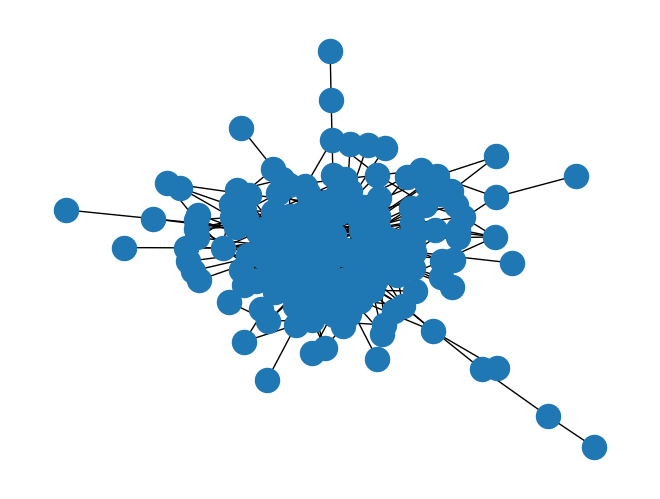

In [13]:
nx.draw(G)

In [64]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.data import Data

class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=-1)

def train():
    model.train()
    optimizer.zero_grad()
    
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.edge_index[1]], data.edge_attr.squeeze().long())
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
    pred = out[data.edge_index[1]].max(dim=1)[1]
    correct = pred.eq(data.edge_attr.squeeze().long()).sum().item()
    acc = correct / len(pred)
    return acc

# Model and optimizer
hidden_channels = 32
num_classes = len(torch.unique(data.edge_attr))
model = GCN(1, hidden_channels, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training and testing
for epoch in range(200):
    loss = train()
    if epoch % 10 == 0:
        acc = test()
        print(f"Epoch: {epoch}, Loss: {loss:.4f}, Acc: {acc:.4f}")


Epoch: 0, Loss: 62.2777, Acc: 0.2563
Epoch: 10, Loss: 46.8673, Acc: 0.2225
Epoch: 20, Loss: 29.3596, Acc: 0.2563
Epoch: 30, Loss: 21.1157, Acc: 0.2282
Epoch: 40, Loss: 17.3611, Acc: 0.2225
Epoch: 50, Loss: 12.1617, Acc: 0.2930
Epoch: 60, Loss: 6.7670, Acc: 0.2225
Epoch: 70, Loss: 8.0774, Acc: 0.2930
Epoch: 80, Loss: 4.4933, Acc: 0.2225
Epoch: 90, Loss: 3.8601, Acc: 0.2282
Epoch: 100, Loss: 2.3946, Acc: 0.2282
Epoch: 110, Loss: 1.9150, Acc: 0.2197
Epoch: 120, Loss: 2.0377, Acc: 0.2282
Epoch: 130, Loss: 1.5237, Acc: 0.2225
Epoch: 140, Loss: 1.4246, Acc: 0.2648
Epoch: 150, Loss: 1.3978, Acc: 0.2930
Epoch: 160, Loss: 1.3931, Acc: 0.2930
Epoch: 170, Loss: 1.3879, Acc: 0.2930
Epoch: 180, Loss: 1.3869, Acc: 0.2930
Epoch: 190, Loss: 1.3792, Acc: 0.2930


In [65]:
# 1. Create a new graph G_unknown with the nodes and edges from unknown_mood_df
G_unknown = nx.Graph()
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

hidden_channels = 32
num_classes = max(known_mood_df['mood']) + 1
gcn = GCN(1, hidden_channels, num_classes)
model = GAE(gcn)
# Add user and item nodes
G_unknown.add_nodes_from([(node, {'bipartite': 0, 'color': 'red'}) for node in unknown_mood_df['UserID'].unique()])
G_unknown.add_nodes_from([(node, {'bipartite': 1, 'color': 'yellow'}) for node in unknown_mood_df['ItemID'].unique()])

# Add edges without mood attribute
G_unknown.add_edges_from([(row['UserID'], row['ItemID']) for _, row in unknown_mood_df.iterrows()])

# 2. Convert the graph to a PyTorch Geometric data object
edge_index_unknown = torch.tensor(list(G_unknown.edges), dtype=torch.long).t().contiguous()
x_unknown = torch.tensor(range(len(G_unknown.nodes)), dtype=torch.float).view(-1, 1)

data_unknown = Data(x=x_unknown, edge_index=edge_index_unknown)

# 3. Use the trained GCN model to get embeddings for the user and item nodes
model.eval()
z_unknown = model.encode(data_unknown.x, data_unknown.edge_index)

# 4. Calculate the similarity scores and choose the class with the highest similarity score
missing_edges_unknown = [(row['UserID'], row['ItemID']) for _, row in unknown_mood_df.iterrows()]
missing_edges_tensor_unknown = torch.tensor(missing_edges_unknown, dtype=torch.long).t()
predicted_moods_unknown = torch.matmul(z_unknown[missing_edges_tensor_unknown[0]], z_unknown[missing_edges_tensor_unknown[1]].t()).argmax(dim=1).cpu().numpy()

# 5. Add the predicted moods to the unknown_mood_df
unknown_mood_df['mood'] = mood_le.inverse_transform(predicted_moods_unknown)


RuntimeError: index 715 is out of bounds for dimension 0 with size 181

In [11]:
import pandas as pd

In [12]:
df = pd.read_csv('C:/Users/thanh/Downloads/D1.csv')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6110 entries, 0 to 6109
Data columns (total 43 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   survey_date             6110 non-null   object 
 1   region                  1659 non-null   object 
 2   country                 6107 non-null   object 
 3   ip_latitude             6110 non-null   float64
 4   ip_longitude            6110 non-null   float64
 5   ip_accuracy             6110 non-null   int64  
 6   gender                  6110 non-null   object 
 7   age                     6110 non-null   object 
 8   height                  6110 non-null   int64  
 9   weight                  6110 non-null   int64  
 10  bmi                     6110 non-null   float64
 11  blood_type              5997 non-null   object 
 12  insurance               4758 non-null   object 
 13  income                  4916 non-null   object 
 14  race                    4942 non-null   

In [1]:
import multiprocessing

print(f"Number of CPU cores available: {multiprocessing.cpu_count()}")

Number of CPU cores available: 8
